# Feature selection for Linear Regression on the Possum Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Read Possum data to dataframe

In [2]:
possum = pd.read_csv('possum.csv')
print(possum.head())

   case  site  Pop sex  age  hdlngth  skullw  totlngth  taill  footlgth  \
0     1     1  Vic   m  8.0     94.1    60.4      89.0   36.0      74.5   
1     2     1  Vic   f  6.0     92.5    57.6      91.5   36.5      72.5   
2     3     1  Vic   f  6.0     94.0    60.0      95.5   39.0      75.4   
3     4     1  Vic   f  6.0     93.2    57.1      92.0   38.0      76.1   
4     5     1  Vic   f  2.0     91.5    56.3      85.5   36.0      71.0   

   earconch   eye  chest  belly  
0      54.5  15.2   28.0   36.0  
1      51.2  16.0   28.5   33.0  
2      51.9  15.5   30.0   34.0  
3      52.2  15.2   28.0   34.0  
4      53.2  15.1   28.5   33.0  


## First preprocessing - delete 'case' column as it is just an index

In [3]:
possum = possum.drop('case', axis=1)
print(possum.head())

   site  Pop sex  age  hdlngth  skullw  totlngth  taill  footlgth  earconch  \
0     1  Vic   m  8.0     94.1    60.4      89.0   36.0      74.5      54.5   
1     1  Vic   f  6.0     92.5    57.6      91.5   36.5      72.5      51.2   
2     1  Vic   f  6.0     94.0    60.0      95.5   39.0      75.4      51.9   
3     1  Vic   f  6.0     93.2    57.1      92.0   38.0      76.1      52.2   
4     1  Vic   f  2.0     91.5    56.3      85.5   36.0      71.0      53.2   

    eye  chest  belly  
0  15.2   28.0   36.0  
1  16.0   28.5   33.0  
2  15.5   30.0   34.0  
3  15.2   28.0   34.0  
4  15.1   28.5   33.0  


## Handle missing data

### count missing values

In [4]:
print(possum.isna().sum())

site        0
Pop         0
sex         0
age         2
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    1
earconch    0
eye         0
chest       0
belly       0
dtype: int64


### calculate threshold for dropping observations with missing values

In [5]:
treshold = len(possum) * 0.05
print(treshold)

5.2


### drop all rows with missing values for columns below treshold

In [6]:
cols_to_drop = possum.columns[possum.isna().sum() <= treshold]
print(cols_to_drop)

Index(['site', 'Pop', 'sex', 'age', 'hdlngth', 'skullw', 'totlngth', 'taill',
       'footlgth', 'earconch', 'eye', 'chest', 'belly'],
      dtype='object')


In [7]:
possum.dropna(subset=cols_to_drop, inplace=True)

In [8]:
print(possum.isna().sum())

site        0
Pop         0
sex         0
age         0
hdlngth     0
skullw      0
totlngth    0
taill       0
footlgth    0
earconch    0
eye         0
chest       0
belly       0
dtype: int64


## Convert categorical data

In [9]:
print(possum.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 103
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   site      101 non-null    int64  
 1   Pop       101 non-null    object 
 2   sex       101 non-null    object 
 3   age       101 non-null    float64
 4   hdlngth   101 non-null    float64
 5   skullw    101 non-null    float64
 6   totlngth  101 non-null    float64
 7   taill     101 non-null    float64
 8   footlgth  101 non-null    float64
 9   earconch  101 non-null    float64
 10  eye       101 non-null    float64
 11  chest     101 non-null    float64
 12  belly     101 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 11.0+ KB
None


#### => We have to deal with Pop and sex. What about site?

In [10]:
print(possum['site'].nunique())

7


Site contains categorical data encoded as ordinal data. Since there is no natural order between the values of site, it may be better to use OneHotEncoding.

####  convert 'Pop' and 'sex' 

In [11]:
print(possum['Pop'].nunique())
print(possum['sex'].nunique())

2
2


Pop and sex contain categorical data with no natural order between the values, so we should use OneHotEncoding (or in this case LabelEncoding as well, as there are just 2 values for each Pop and sex and a LabelEncoding would result in 0 - 1 values.)

In [12]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0, 1, 2])], remainder='passthrough')
X = np.array(ct.fit_transform(possum))
print(X)

[[ 1.   0.   0.  ... 15.2 28.  36. ]
 [ 1.   0.   0.  ... 16.  28.5 33. ]
 [ 1.   0.   0.  ... 15.5 30.  34. ]
 ...
 [ 0.   0.   0.  ... 13.  25.  30. ]
 [ 0.   0.   0.  ... 15.4 25.  29. ]
 [ 0.   0.   0.  ... 14.8 28.5 33.5]]


We now have a numpy matrix with only numerical data and without missing values that we can buil our Regression models from.

### Feature selection techniques

#### 1. Filter method using Pearson correlation matrix

Correlation matrix can only be used on columns with numerical data, so we have to drop the columns site, Pop and sex first.

In [13]:
possum_numerical = possum.drop(['site', 'Pop', 'sex'], axis=1)
print(possum_numerical.head())

   age  hdlngth  skullw  totlngth  taill  footlgth  earconch   eye  chest  \
0  8.0     94.1    60.4      89.0   36.0      74.5      54.5  15.2   28.0   
1  6.0     92.5    57.6      91.5   36.5      72.5      51.2  16.0   28.5   
2  6.0     94.0    60.0      95.5   39.0      75.4      51.9  15.5   30.0   
3  6.0     93.2    57.1      92.0   38.0      76.1      52.2  15.2   28.0   
4  2.0     91.5    56.3      85.5   36.0      71.0      53.2  15.1   28.5   

   belly  
0   36.0  
1   33.0  
2   34.0  
3   34.0  
4   33.0  


In [14]:
cor = possum_numerical.corr()
print(cor)

               age   hdlngth    skullw  totlngth     taill  footlgth  \
age       1.000000  0.329505  0.285563  0.268297  0.120205  0.126190   
hdlngth   0.329505  1.000000  0.705901  0.670402  0.275155  0.415945   
skullw    0.285563  0.705901  1.000000  0.506382  0.241027  0.297197   
totlngth  0.268297  0.670402  0.506382  1.000000  0.563586  0.483174   
taill     0.120205  0.275155  0.241027  0.563586  1.000000 -0.114560   
footlgth  0.126190  0.415945  0.297197  0.483174 -0.114560  1.000000   
earconch  0.066234  0.131576  0.025293  0.181230 -0.387871  0.782415   
eye       0.231857  0.354688  0.314319  0.247150  0.192341  0.013869   
chest     0.335030  0.621068  0.613842  0.556094  0.152924  0.486477   
belly     0.360816  0.545438  0.444216  0.500558  0.296206  0.311970   

          earconch       eye     chest     belly  
age       0.066234  0.231857  0.335030  0.360816  
hdlngth   0.131576  0.354688  0.621068  0.545438  
skullw    0.025293  0.314319  0.613842  0.444216  
tot

##### Visualize the correlation matrix with a heatmap

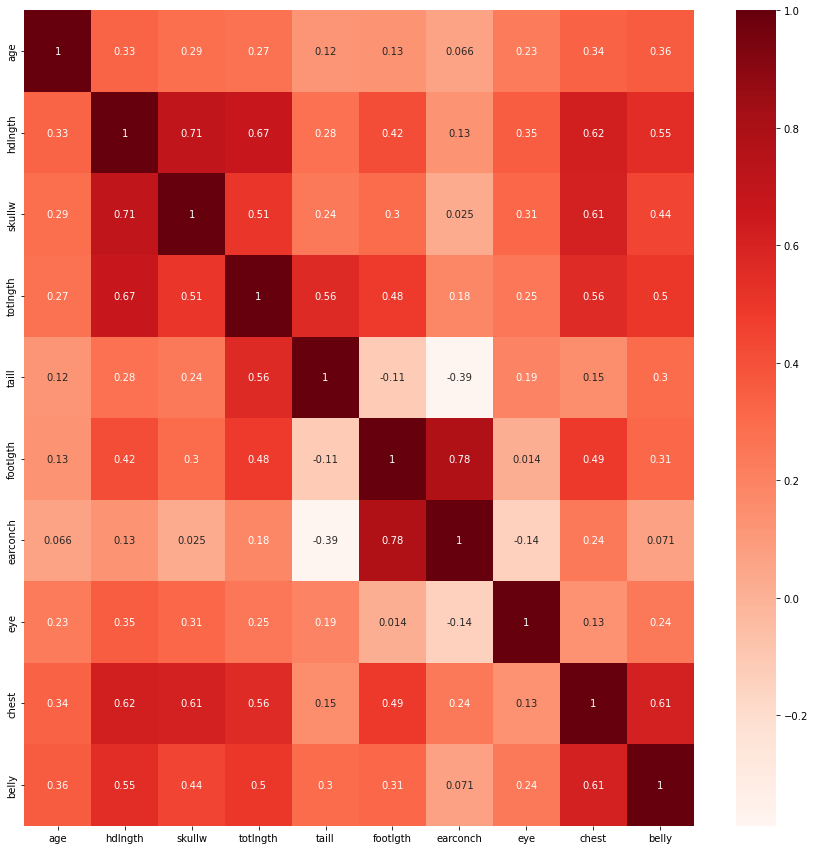

In [15]:
plt.figure(figsize=(15, 15))
#sns.set(font_scale=1.5)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### Select best features subset for target headlength (output variable)

In [16]:
cor_target = abs(cor["hdlngth"])
#print(cor_target)
relevant_features = cor_target[cor_target > 0.5]
print(relevant_features)

hdlngth     1.000000
skullw      0.705901
totlngth    0.670402
chest       0.621068
belly       0.545438
Name: hdlngth, dtype: float64


Now we need to check if the relevant features (skullw, totlngth, chest and belly) are correlated with each other, because for Linear Regression the indenpendent variables need to be uncorrelated with each other.

In [17]:
print(possum_numerical[["skullw", "totlngth"]].corr())

            skullw  totlngth
skullw    1.000000  0.506382
totlngth  0.506382  1.000000


In [18]:
print(possum_numerical[["skullw", "chest"]].corr())

          skullw     chest
skullw  1.000000  0.613842
chest   0.613842  1.000000


In [19]:
print(possum_numerical[["skullw", "belly"]].corr())

          skullw     belly
skullw  1.000000  0.444216
belly   0.444216  1.000000


As we can see skullw and chest are highly correlated with each other, so we drop chest and keep skullw (because it is higher correlated with hdlngth).

In [20]:
print(possum_numerical[["totlngth", "belly"]].corr())

          totlngth     belly
totlngth  1.000000  0.500558
belly     0.500558  1.000000


We keep totlngth and belly with medium correlations between each other (maybe we drop them later if LinearRegression doesn't perform well).

#### => Our subset of best features for prediction of hdlngth is skullw, totlngth and belly. 

#### Let's build a simple Linear Regression Model with these features

In [21]:
X_best_features = possum_numerical[["skullw", "totlngth", "belly"]].iloc[:, :].values
print(X_best_features)
y = possum_numerical[["hdlngth"]].iloc[:, :].values
print(y)

[[60.4 89.  36. ]
 [57.6 91.5 33. ]
 [60.  95.5 34. ]
 [57.1 92.  34. ]
 [56.3 85.5 33. ]
 [54.8 90.5 32. ]
 [58.2 89.5 34.5]
 [57.6 91.  34. ]
 [56.3 91.5 33. ]
 [58.  89.5 32. ]
 [57.2 89.5 34. ]
 [55.6 92.  33. ]
 [59.9 89.5 32. ]
 [57.6 91.5 31.5]
 [57.6 85.5 35. ]
 [56.  86.  32. ]
 [67.7 89.5 31. ]
 [55.7 90.  32. ]
 [55.4 90.5 32. ]
 [56.3 89.  36. ]
 [58.1 96.5 40. ]
 [58.5 91.  36. ]
 [56.1 89.  35. ]
 [54.9 84.  32. ]
 [58.5 91.5 35. ]
 [59.  90.  38. ]
 [54.5 85.  28. ]
 [56.8 87.  30. ]
 [56.  88.  32. ]
 [54.4 84.  33. ]
 [54.1 93.  31. ]
 [56.7 94.  34. ]
 [54.6 89.  30. ]
 [55.7 85.5 28.5]
 [57.9 85.  35.5]
 [59.3 88.  36. ]
 [54.8 82.5 31.5]
 [56.  80.5 30. ]
 [51.5 75.  25. ]
 [55.  84.5 30. ]
 [54.1 77.  33. ]
 [55.5 81.  31. ]
 [55.9 81.  31.5]
 [54.8 89.  33. ]
 [63.2 85.  35. ]
 [59.2 85.  35.5]
 [56.4 88.  36. ]
 [59.6 85.  38.5]
 [61.  93.5 32.5]
 [58.1 91.  33.5]
 [63.  91.5 36.5]
 [63.2 92.5 36. ]
 [61.5 93.7 31.5]
 [59.4 93.  39. ]
 [64.2 91.  33. ]
 [62.8 96.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_best_features, y, random_state=0)

In [23]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [24]:
y_pred = regressor.predict(X_test)

In [25]:
print(r2_score(y_test, y_pred))

0.2231532562589238


#### => poor result! Why does the algorithm perform so bad with the selected features? Without skullw the preformance is better.

In [26]:
print(possum_numerical[["skullw", "totlngth", "belly"]].corr())

            skullw  totlngth     belly
skullw    1.000000  0.506382  0.444216
totlngth  0.506382  1.000000  0.500558
belly     0.444216  0.500558  1.000000


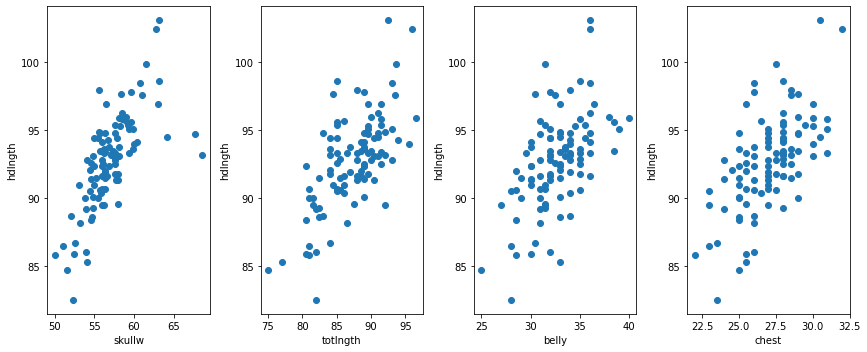

In [27]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 4, 1)
plt.scatter(possum_numerical["skullw"], possum_numerical["hdlngth"])
plt.xlabel("skullw")
plt.ylabel("hdlngth")

plt.subplot(1, 4, 2)
plt.scatter(possum_numerical["totlngth"], possum_numerical["hdlngth"])
plt.xlabel("totlngth")
plt.ylabel("hdlngth")

plt.subplot(1, 4, 3)
plt.scatter(possum_numerical["belly"], possum_numerical["hdlngth"])
plt.xlabel("belly")
plt.ylabel("hdlngth")

plt.subplot(1, 4, 4)
plt.scatter(possum_numerical["chest"], possum_numerical["hdlngth"])
plt.xlabel("chest")
plt.ylabel("hdlngth")

plt.tight_layout()
plt.show()

#### Visualize interaction between different features using pairplot

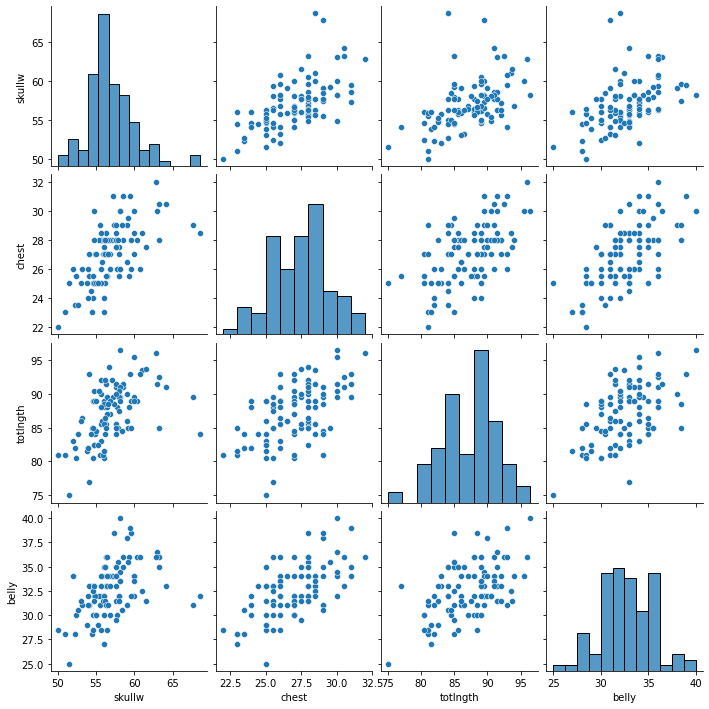

In [34]:
sns.pairplot(possum_numerical[["skullw", "chest", "totlngth", "belly"]])
plt.show()

#### Try to perform better with chest, totlngth and belly (correlation matrix find's the highest correlations but may not find the best subset)

In [29]:
X_best_features = possum_numerical[["chest", "totlngth", "belly"]].iloc[:, :].values
print(X_best_features)
y = possum_numerical[["hdlngth"]].iloc[:, :].values
print(y)

[[28.  89.  36. ]
 [28.5 91.5 33. ]
 [30.  95.5 34. ]
 [28.  92.  34. ]
 [28.5 85.5 33. ]
 [30.  90.5 32. ]
 [30.  89.5 34.5]
 [29.  91.  34. ]
 [28.  91.5 33. ]
 [27.5 89.5 32. ]
 [31.  89.5 34. ]
 [28.  92.  33. ]
 [27.  89.5 32. ]
 [28.  91.5 31.5]
 [28.  85.5 35. ]
 [28.  86.  32. ]
 [29.  89.5 31. ]
 [28.  90.  32. ]
 [28.  90.5 32. ]
 [27.  89.  36. ]
 [30.  96.5 40. ]
 [28.  91.  36. ]
 [28.  89.  35. ]
 [27.  84.  32. ]
 [31.  91.5 35. ]
 [29.  90.  38. ]
 [23.  85.  28. ]
 [27.  87.  30. ]
 [24.  88.  32. ]
 [24.5 84.  33. ]
 [27.  93.  31. ]
 [28.  94.  34. ]
 [24.  89.  30. ]
 [26.  85.5 28.5]
 [28.  85.  35.5]
 [25.5 88.  36. ]
 [28.  82.5 31.5]
 [27.  80.5 30. ]
 [25.  75.  25. ]
 [27.  84.5 30. ]
 [25.5 77.  33. ]
 [29.  81.  31. ]
 [27.  81.  31.5]
 [25.  89.  33. ]
 [28.  85.  35. ]
 [29.5 85.  35.5]
 [28.  88.  36. ]
 [28.  85.  38.5]
 [28.5 93.5 32.5]
 [26.  91.  33.5]
 [30.  91.5 36.5]
 [30.5 92.5 36. ]
 [27.5 93.7 31.5]
 [31.  93.  39. ]
 [30.5 91.  33. ]
 [32.  96.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_best_features, y, random_state=0)

In [31]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [32]:
y_pred = regressor.predict(X_test)

In [33]:
print(r2_score(y_test, y_pred))

0.6307883891506672


#### => With this subset of features the algorithm performs much better! Maybe there's still to much correlation between skullw and the other features or the outliers in data affect the result. Maybe we get better with an other Linear Regression model....